# Feature Extractor

In [1]:
import tensorflow as tf
tf.random.set_seed(221)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from mnist import MNIST
import cv2
import os

extract_feature = True

Resnet18

In [2]:
if extract_feature:
    import timm

    model = timm.create_model(
        'vgg19.tv_in1k',
        pretrained=True,
        num_classes=0,  # remove classifier nn.Linear
    )
    model = model.eval()

    # get model specific transforms (normalization, resize)
    data_config = timm.data.resolve_model_data_config(model)
    transforms = timm.data.create_transform(**data_config, is_training=False)


Load pictures from folders

In [3]:
def load_images_from_folders(base_path):
    images = []
    labels = []

    # Traverse the base directory
    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)
        
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                
                try:
                    # Open and load the image
                    with Image.open(image_path) as img:
                        images.append(img.copy())
                        labels.append(label)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
    
    return images, labels


In [4]:
# train
base_path = 'E:/Work/DS/Datasets/Raw/Industrial/Texture/Splited/train'
train_images, train_labels = load_images_from_folders(base_path)

# Print the number of images loaded and their corresponding labels
print(f"Number of images loaded: {len(train_images)}")
print(f"Labels: {set(train_labels)}")

Number of images loaded: 4335
Labels: {'KTH_aluminium_foil', 'UIUC08_granite', 'Kyberge_scarf2', 'UIUC02_bark2', 'UIUC04_wood1', 'UIUC16_glass1', 'UIUC14_brick1', 'UIUC10_floor1', 'Kyberge_stone2', 'Kyberge_seat2', 'UIUC15_brick2', 'Kyberge_seat1', 'UIUC19_carpet2', 'Kyberge_blanket2', 'Kyberge_grass1', 'Kyberge_cushion1', 'Kyberge_stoneslab1', 'KTH_cork', 'UIUC03_bark3', 'Kyberge_blanket1', 'UIUC09_marble', 'KTH_wool', 'Kyberge_scarf1', 'Kyberge_floor1', 'Kyberge_screen1', 'UIUC05_wood2', 'Kyberge_rice1', 'UIUC12_pebbles', 'KTH_brown_bread', 'UIUC18_carpet1', 'UIUC01_bark1', 'UIUC11_floor2', 'Kyberge_rug1', 'Kyberge_sesameseeds1', 'Kyberge_lentils1', 'KTH_orange_peel', 'Kyberge_linseeds1', 'Kyberge_ceiling1', 'Kyberge_pearlsugar1', 'Kyberge_sand1', 'UIUC17_glass2', 'UIUC25_plaid', 'KTH_corduroy', 'UIUC24_corduroy', 'Kyberge_floor2', 'UIUC22_fur', 'KTH_styrofoam', 'KTH_sponge', 'Kyberge_stone1', 'Kyberge_wall1', 'UIUC23_knit', 'KTH_linen', 'Kyberge_oatmeal1', 'Kyberge_stone3', 'Kyberge

In [5]:
# test
base_path = 'E:/Work/DS/Datasets/Raw/Industrial/Texture/Splited/valid'
valid_images, valid_labels = load_images_from_folders(base_path)

# Print the number of images loaded and their corresponding labels
print(f"Number of images loaded: {len(valid_images)}")
print(f"Labels: {set(valid_labels)}")

Number of images loaded: 4340
Labels: {'KTH_aluminium_foil', 'UIUC08_granite', 'Kyberge_scarf2', 'UIUC02_bark2', 'UIUC04_wood1', 'UIUC16_glass1', 'UIUC14_brick1', 'UIUC10_floor1', 'Kyberge_stone2', 'Kyberge_seat2', 'UIUC15_brick2', 'Kyberge_seat1', 'UIUC19_carpet2', 'Kyberge_blanket2', 'Kyberge_grass1', 'Kyberge_cushion1', 'Kyberge_stoneslab1', 'KTH_cork', 'UIUC03_bark3', 'Kyberge_blanket1', 'UIUC09_marble', 'KTH_wool', 'Kyberge_scarf1', 'Kyberge_floor1', 'Kyberge_screen1', 'UIUC05_wood2', 'Kyberge_rice1', 'UIUC12_pebbles', 'KTH_brown_bread', 'UIUC18_carpet1', 'UIUC01_bark1', 'UIUC11_floor2', 'Kyberge_rug1', 'Kyberge_sesameseeds1', 'Kyberge_lentils1', 'KTH_orange_peel', 'Kyberge_linseeds1', 'Kyberge_ceiling1', 'Kyberge_pearlsugar1', 'Kyberge_sand1', 'UIUC17_glass2', 'UIUC25_plaid', 'KTH_corduroy', 'UIUC24_corduroy', 'Kyberge_floor2', 'UIUC22_fur', 'KTH_styrofoam', 'KTH_sponge', 'Kyberge_stone1', 'Kyberge_wall1', 'UIUC23_knit', 'KTH_linen', 'Kyberge_oatmeal1', 'Kyberge_stone3', 'Kyberge

Will manually split later

In [6]:
images = train_images + valid_images
labels = train_labels + valid_labels

In [7]:
len(images)

8675

Test print image from Cifar 10

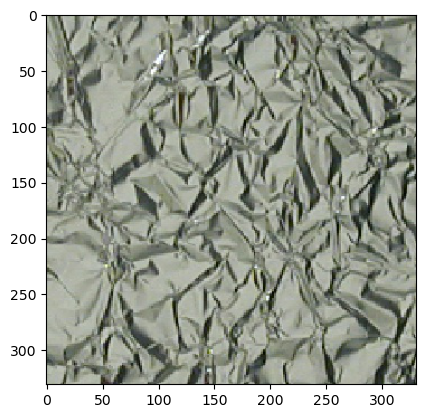

In [8]:
if extract_feature:
    img = train_images[0]
    plt.imshow(img)
    plt.show()

Process images from the cifar10 for the unwrapper

In [9]:
def process_minibatch(minibatch):
    batch_data = []
    for img in minibatch:
        # Convert to PIL image format
        # transform to model format and stack
        img = transforms(img)
        batch_data.append(img)
    batch_data = torch.stack(batch_data)
    # run through the resnet
    processed_data = model(batch_data)
    return processed_data

In [10]:
def feature_extraction(images,labels):

    output_df = pd.DataFrame(columns=['Class'])

    MINIBATCH_SIZE = 347

    # Convert the list of images to a batch tensor
    NUMBER_MINIBATCH = 8675/MINIBATCH_SIZE
    for i in range(0,int(NUMBER_MINIBATCH)):
        print('processing minibatch %d out of %d' %(i+1 , int(NUMBER_MINIBATCH)))
        minibatch = images[i*MINIBATCH_SIZE:(i+1)*MINIBATCH_SIZE]

        # get features and put into df format
        minibatch_output = process_minibatch(minibatch)
        minibatch_output_df = pd.DataFrame(minibatch_output.detach().numpy(), columns=[f'features_{i}' for i in range(4096)])
        minibatch_output_df['Class'] = labels[i*MINIBATCH_SIZE:(i+1)*MINIBATCH_SIZE]

        output_df = pd.concat([output_df, minibatch_output_df], ignore_index=True)
    return output_df

In [11]:
import pandas as pd
if extract_feature:
    train = feature_extraction(images,labels)
    train.to_csv('extracted_features.csv', index = False)
else:
    train = pd.read_csv('extracted_features.csv')


processing minibatch 1 out of 25
processing minibatch 2 out of 25
processing minibatch 3 out of 25
processing minibatch 4 out of 25
processing minibatch 5 out of 25
processing minibatch 6 out of 25
processing minibatch 7 out of 25
processing minibatch 8 out of 25
processing minibatch 9 out of 25
processing minibatch 10 out of 25
processing minibatch 11 out of 25
processing minibatch 12 out of 25
processing minibatch 13 out of 25
processing minibatch 14 out of 25
processing minibatch 15 out of 25
processing minibatch 16 out of 25
processing minibatch 17 out of 25
processing minibatch 18 out of 25
processing minibatch 19 out of 25
processing minibatch 20 out of 25
processing minibatch 21 out of 25
processing minibatch 22 out of 25
processing minibatch 23 out of 25
processing minibatch 24 out of 25
processing minibatch 25 out of 25


In [12]:
print(train.head())
print(train.shape)

                Class  features_0  features_1  features_2  features_3  \
0  KTH_aluminium_foil    0.237628         0.0    0.095382         0.0   
1  KTH_aluminium_foil    0.000000         0.0    0.000000         0.0   
2  KTH_aluminium_foil    0.000000         0.0    0.000000         0.0   
3  KTH_aluminium_foil    0.000000         0.0    0.000000         0.0   
4  KTH_aluminium_foil    0.000000         0.0    0.095289         0.0   

   features_4  features_5  features_6  features_7  features_8  ...  \
0         0.0    0.063439    0.000000    0.644707         0.0  ...   
1         0.0    0.000000    0.000000    0.000000         0.0  ...   
2         0.0    0.000000    0.165073    0.000000         0.0  ...   
3         0.0    0.693195    0.000000    0.000000         0.0  ...   
4         0.0    0.213426    0.000000    0.000000         0.0  ...   

   features_4086  features_4087  features_4088  features_4089  features_4090  \
0            0.0            0.0       0.000000       1.37894

Do the same for test set